Note: Please make a copy of this notebook in your drive before working on it.

# Land cover type mapping using Deep Convolutional Neural Nets

This note book is the wraper implementation of land cover mapping using UNet which is a convolutionaneural network architecture designed for image segmentation. The dataset used for this experiment is mainly sentinel-2 harmonized meltispectral imageries (see dataset details [HERE](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED)) which are cloud free compsoites for dry season in Uganda. The composites are made using the median of the spectral values of the bands across time. The compositing, sampling and exporting is done using the provided code /content/drive/MyDrive/code/datadownload.npynb For the computational reason, this experiment uses only 10 meter spatial reolsution bands(Red, Blue, Green and NIR). The labels are also taken from [ESA landcover global 10 meters product](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200). There is also alternative dataset included from Digital glob land cover classification. this dataset could serve as real world challenge on how to preprocess and make it ready for model training. The details of the datset can be accessed from [DeepGlob kaggel site](https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset). in both datsets, please bear in mind that this ground truth masks are not perfect but used for the purpose of demonstrating the experiment. Given deep learning models require dedicated graphics card to speed up the computation, we are using a free cloud computing environment provided by Google, __[Google Colab](https://colab.research.google.com/)__. The details are provided as follows.

---

## Import necessay packages

In [1]:
import kagglehub
# from google.colab import drive
import numpy as np
import os
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import from_levels_and_colors
from skimage.io import imread

Next, create a folder/directory (say project_folder) in your drive to create a workspace for the project. Then navigate to the directory using the cell below.

Change the working directory to the workspace where every data is accessible

<!-- ## Mounting the Google Drive -->

In [1]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')
print("The working directory is: ", os.getcwd())
print("The working directory contains the following folders: ", os.listdir(os.getcwd()))

## Download and Unzip the Dataset
The dataset is hosted in the [Kaggel](https://www.kaggle.com/) under my account as public dataset. It can be downloaded to the google colab environment as follows

In [4]:
path = kagglehub.dataset_download("getachewworkineh/uganda-landcover")
print("Path to dataset files:", path)
# print('Unziping the dataset')
# !unzip uganda-landcover.zip -d data/

100%|██████████| 3.23G/3.23G [02:32<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /home/getch/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/1


In [4]:
# check list of folders in the data path
# os.listdir(f'{path}')
os.listdir('/home/getch/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/2/landcover_data_v2')

['valid', 'test', 'train']

In [8]:
import getpass
import os

Then we have two choices. Either directly access the datasets from /root/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/1/samples or moveit to the more accessible folder with short path /content/drive/MyDrive

In [9]:
# !sudo mv /root/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/1/samples /home/getch/ssl/GORILLA/
# passs = getpass.getpass()
# command = "!sudo mv /root/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/1/samples /home/getch/ssl/GORILLA/"
# os.system('echo %s | %s' % (passs, command))

In [5]:
# to make sure the datasets are moved to the workspace
os.listdir(os.getcwd())

[]

## Descriptive analytics
### Image source and preparation steps:
The accessed dataset is obtained preprocessed using the workflows presented in the Notebook with name /content/drive/MyDrive/code/datadownload.npynb

### Understanding class distribution
the computation of class distribution and its visualization is provided with a script `summerise_distribution.py`. Its very important to understand class destribution and adjust the class weights while training the model. This mainly important for multi-class segmentation task with datasets that have imbalanced class destribution.

<u> Warning:</u>  The script might take couple of minutes to compute as it reads and summerized each dataset label

To visualize the the class distribution run the following script
```python
%matplotlib inline
%run summerise_distribution.py

```

Total train data:  932


100%|██████████| 932/932 [00:22<00:00, 40.92it/s]


Cover type Tree cover: 21.233
Cover type Shrubland: 18.602
Cover type Grassland: 14.57
Cover type Cropland: 4.796
Cover type Built-up: 1.719
Cover type Bare/sparse vegetation: 0.069
Cover type Snow and ice: 0.0
Cover type Permanent water bodies: 34.471
Cover type Herbaceous wetland: 4.539
Cover type Mangroves: 0.0
Cover type Moss and lichen: 0.0


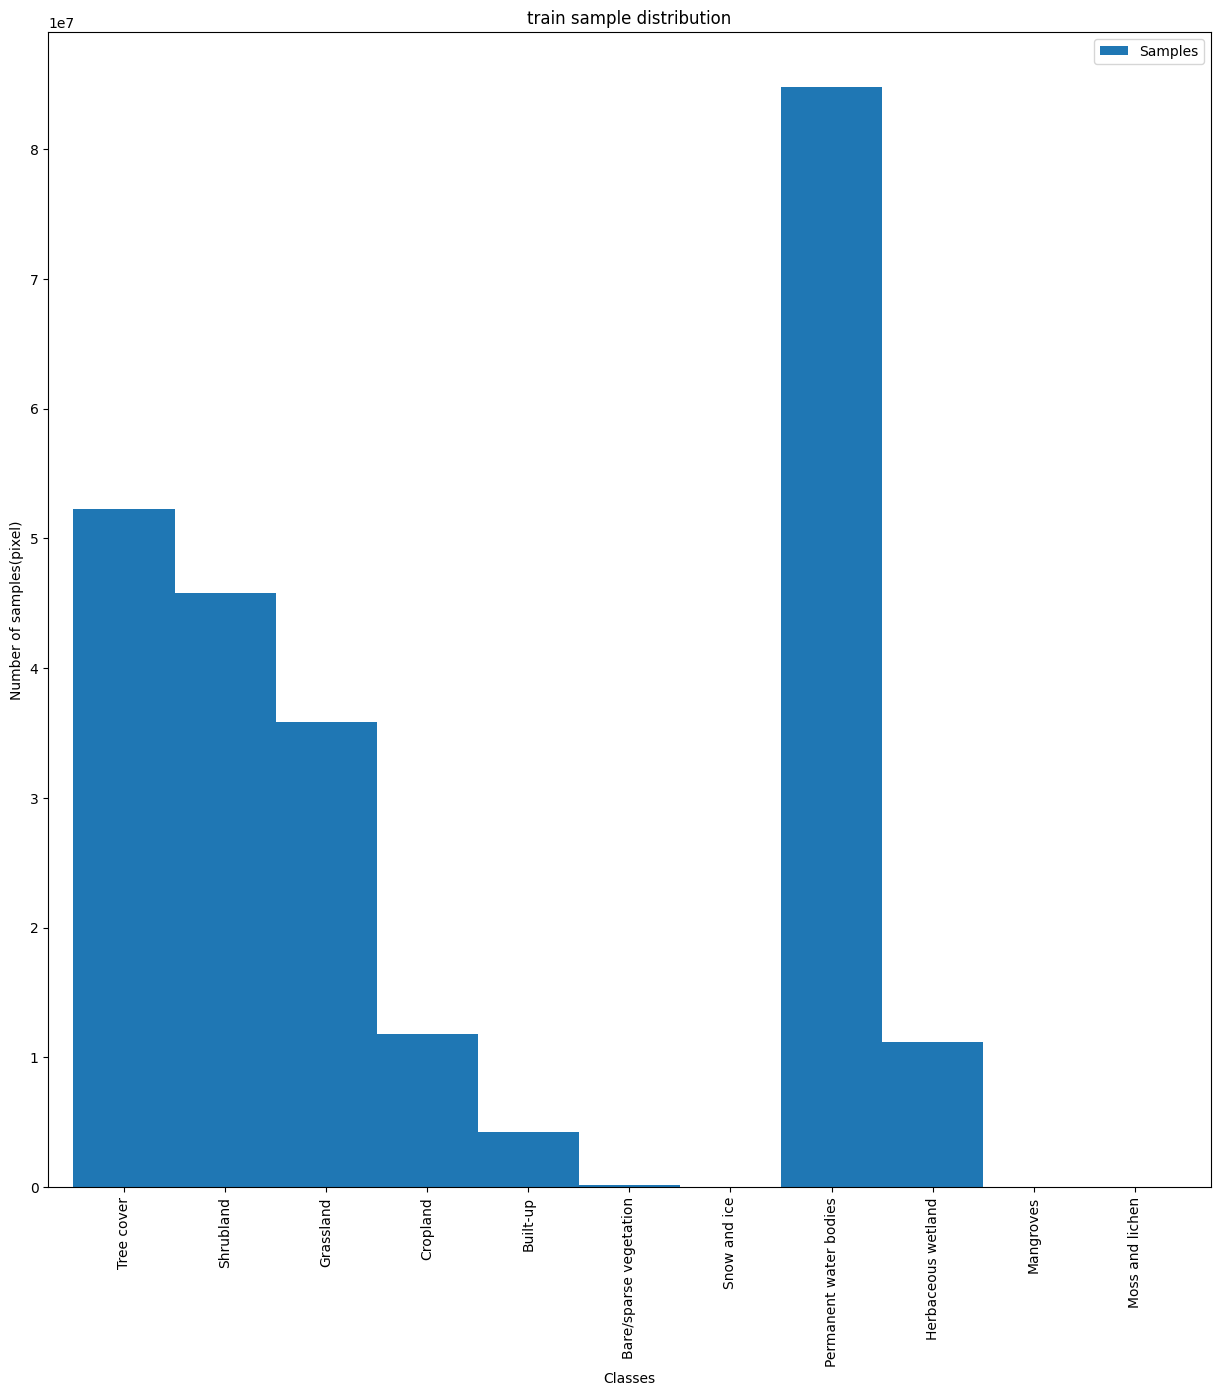

Total test data:  697


100%|██████████| 697/697 [00:16<00:00, 42.99it/s]


Cover type Tree cover: 23.387
Cover type Shrubland: 23.666
Cover type Grassland: 25.929
Cover type Cropland: 13.44
Cover type Built-up: 0.302
Cover type Bare/sparse vegetation: 0.088
Cover type Snow and ice: 0.0
Cover type Permanent water bodies: 9.943
Cover type Herbaceous wetland: 3.246
Cover type Mangroves: 0.0
Cover type Moss and lichen: 0.0


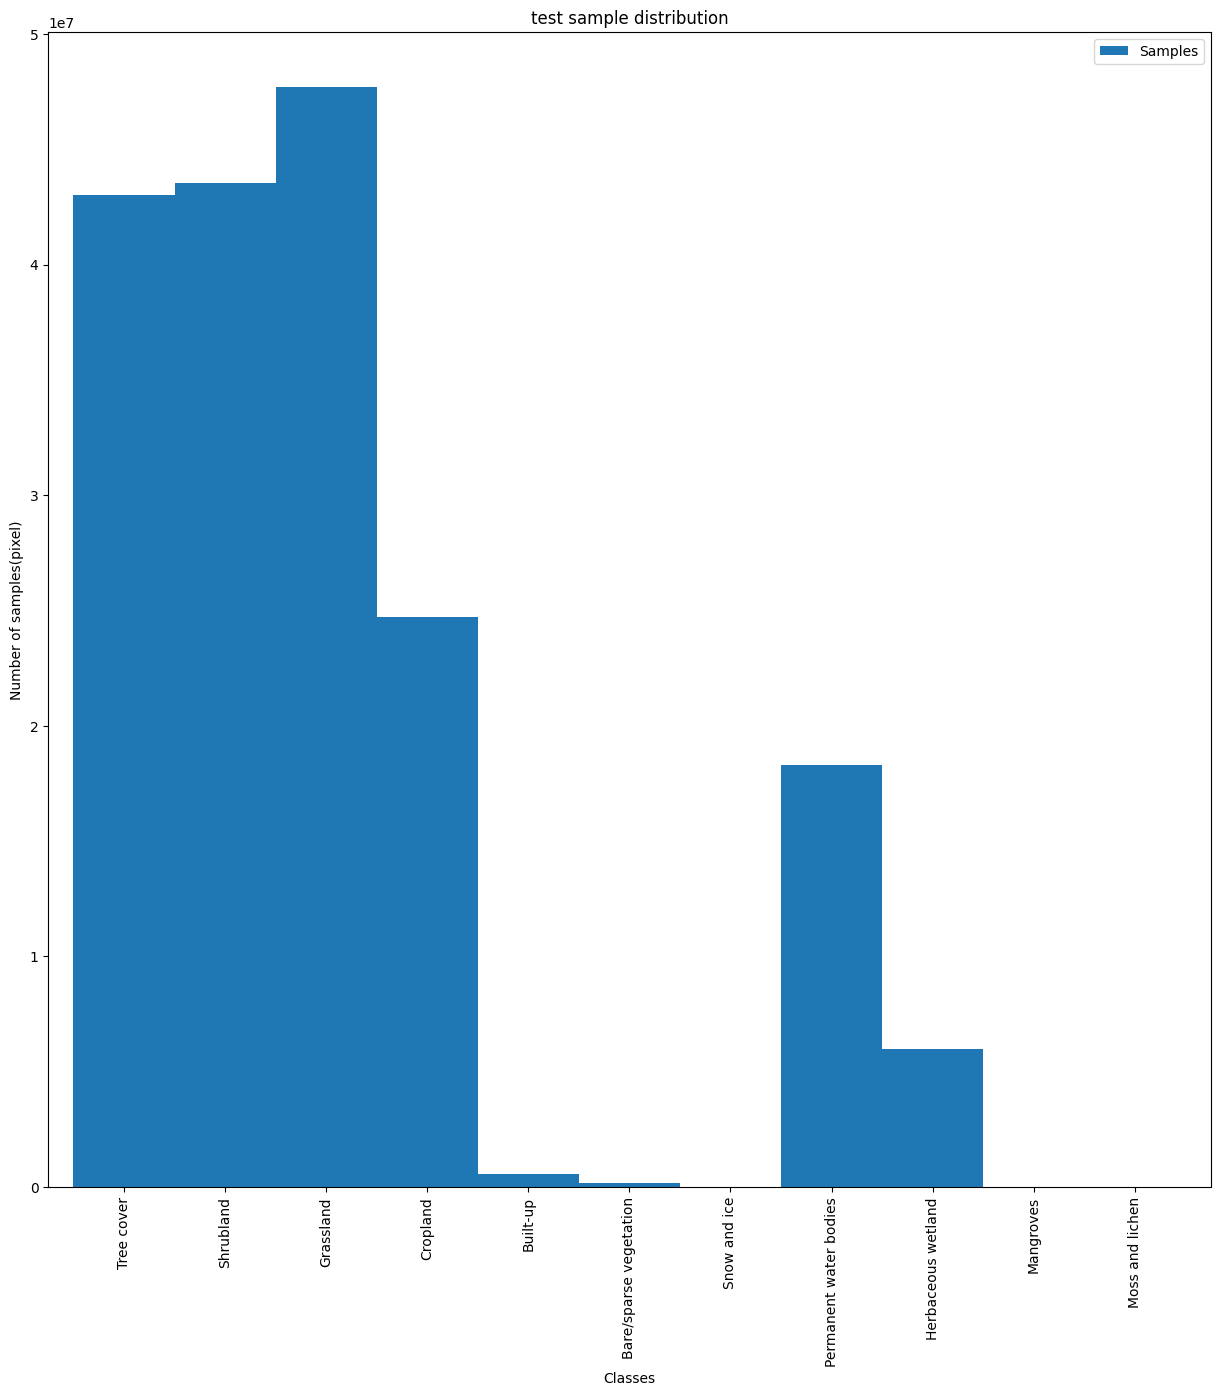

Total valid data:  466


100%|██████████| 466/466 [00:09<00:00, 51.15it/s]


Cover type Tree cover: 21.067
Cover type Shrubland: 19.127
Cover type Grassland: 14.743
Cover type Cropland: 4.755
Cover type Built-up: 1.454
Cover type Bare/sparse vegetation: 0.06
Cover type Snow and ice: 0.0
Cover type Permanent water bodies: 34.388
Cover type Herbaceous wetland: 4.407
Cover type Mangroves: 0.0
Cover type Moss and lichen: 0.0


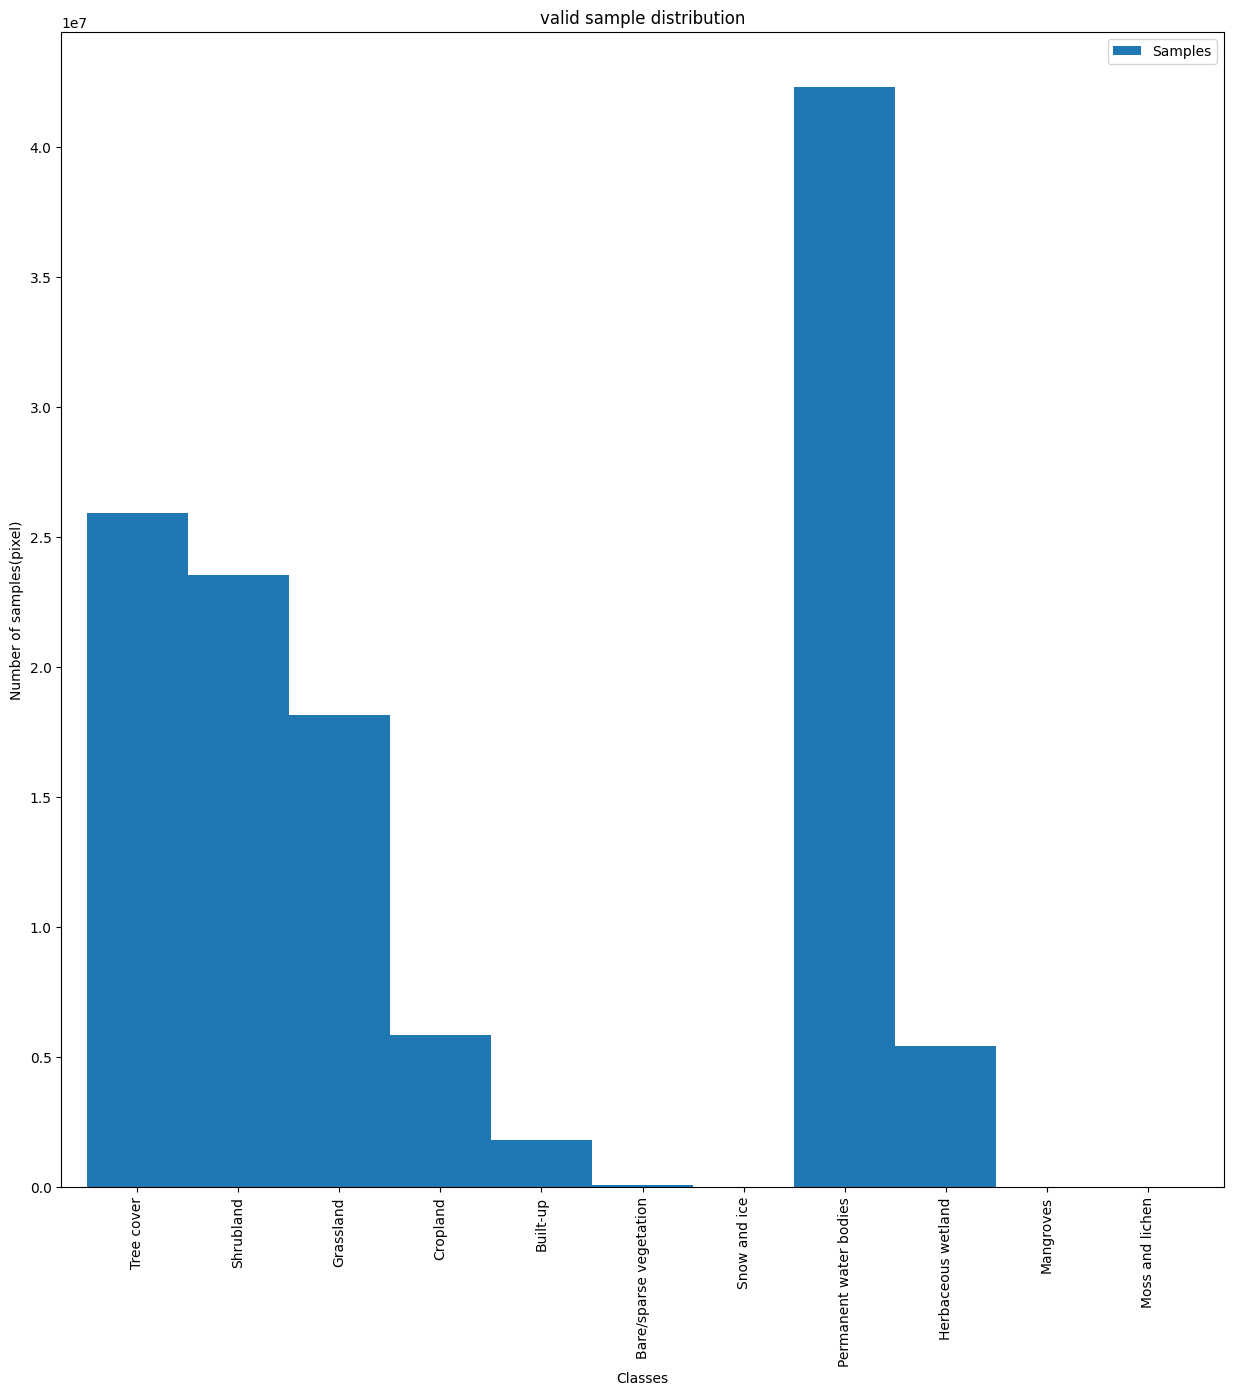

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
%run code/summerise_distribution.py

From the figures presented above and the percent statistics of the classes in each dataset we can observe two patterns.
-- three land cover classes (snow and ice, Mangroves, Mosses and lichens) are not completely observed in the dataset. Despite the fact that global ESA land cover product contains 11 classes, in Ugana there are only 8 classes. Therefore, we have to redfeine the classes with the order from `1 to 8` as we demand continues class index for multi-class segmentation task(during model definition and performing accuracy). Distributions without missing classes can be explored by using:
```python
%matplotlib inline
%run code/summerise_distribution_filter.py
```
as provided in the following cell

Total train data:  932


100%|██████████| 932/932 [00:24<00:00, 38.30it/s]


Cover type Tree cover: 21.233
Cover type Shrubland: 18.602
Cover type Grassland: 14.57
Cover type Cropland: 4.796
Cover type Built-up: 1.719
Cover type Bare/sparse vegetation: 0.069
Cover type Permanent water bodies: 34.471
Cover type Herbaceous wetland: 4.539


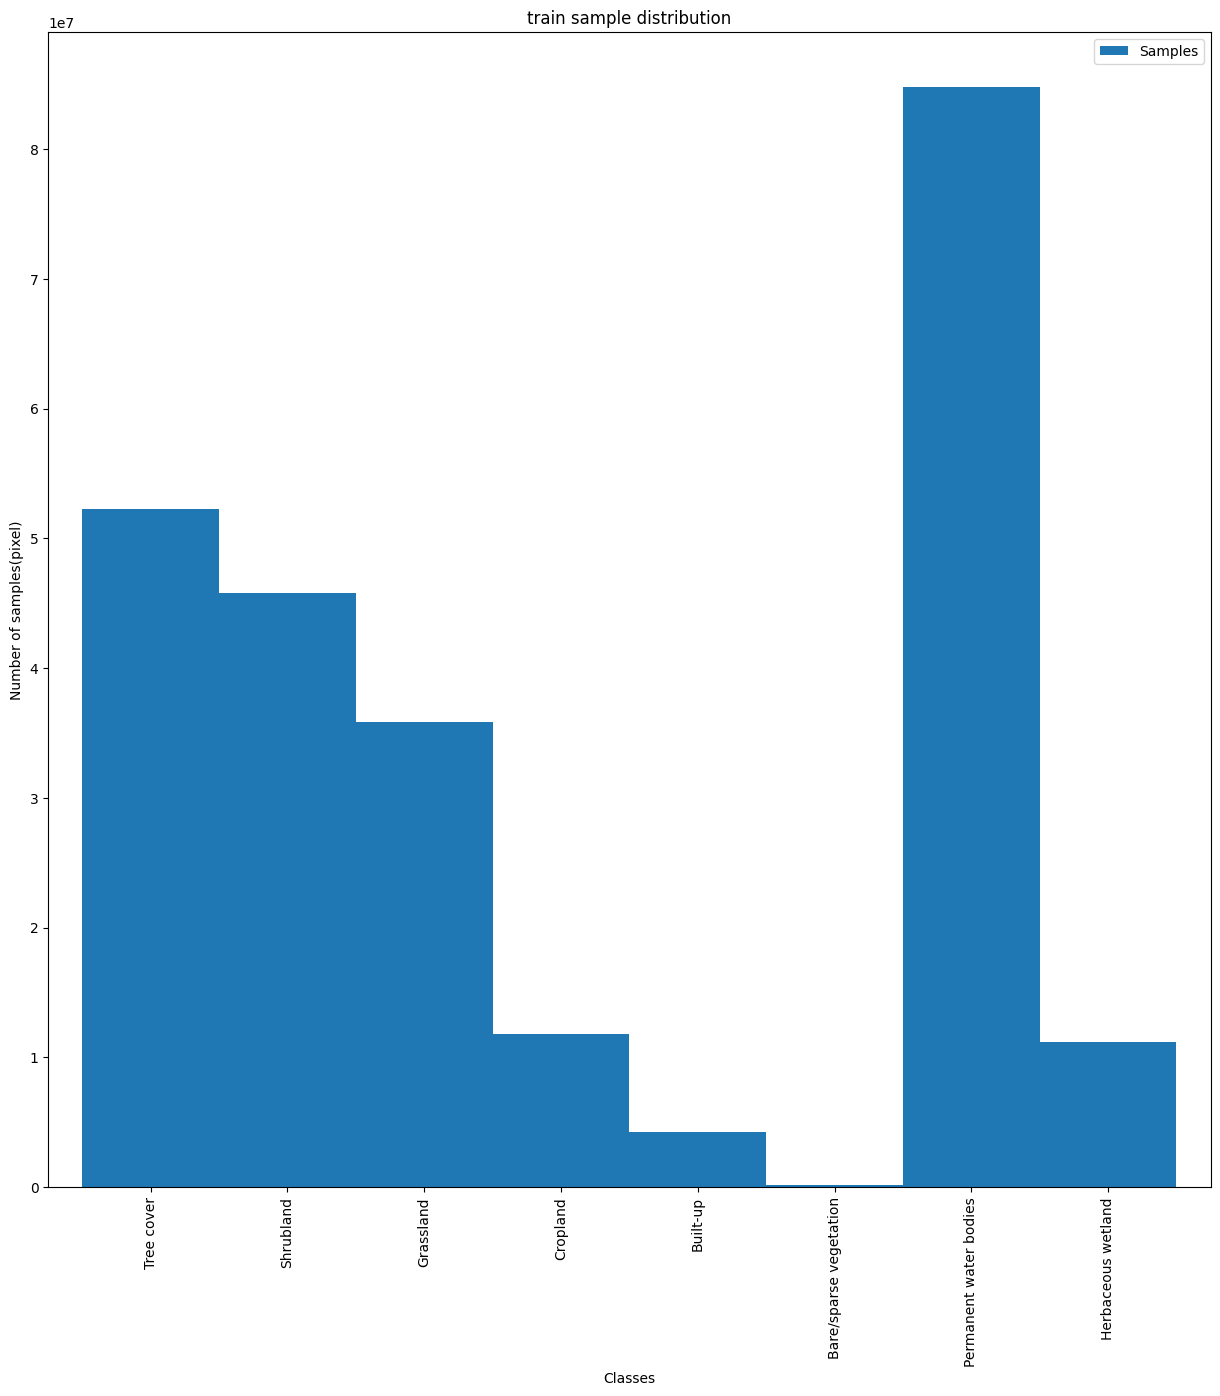

Total test data:  697


100%|██████████| 697/697 [00:15<00:00, 44.20it/s]


Cover type Tree cover: 23.387
Cover type Shrubland: 23.666
Cover type Grassland: 25.929
Cover type Cropland: 13.44
Cover type Built-up: 0.302
Cover type Bare/sparse vegetation: 0.088
Cover type Permanent water bodies: 9.943
Cover type Herbaceous wetland: 3.246


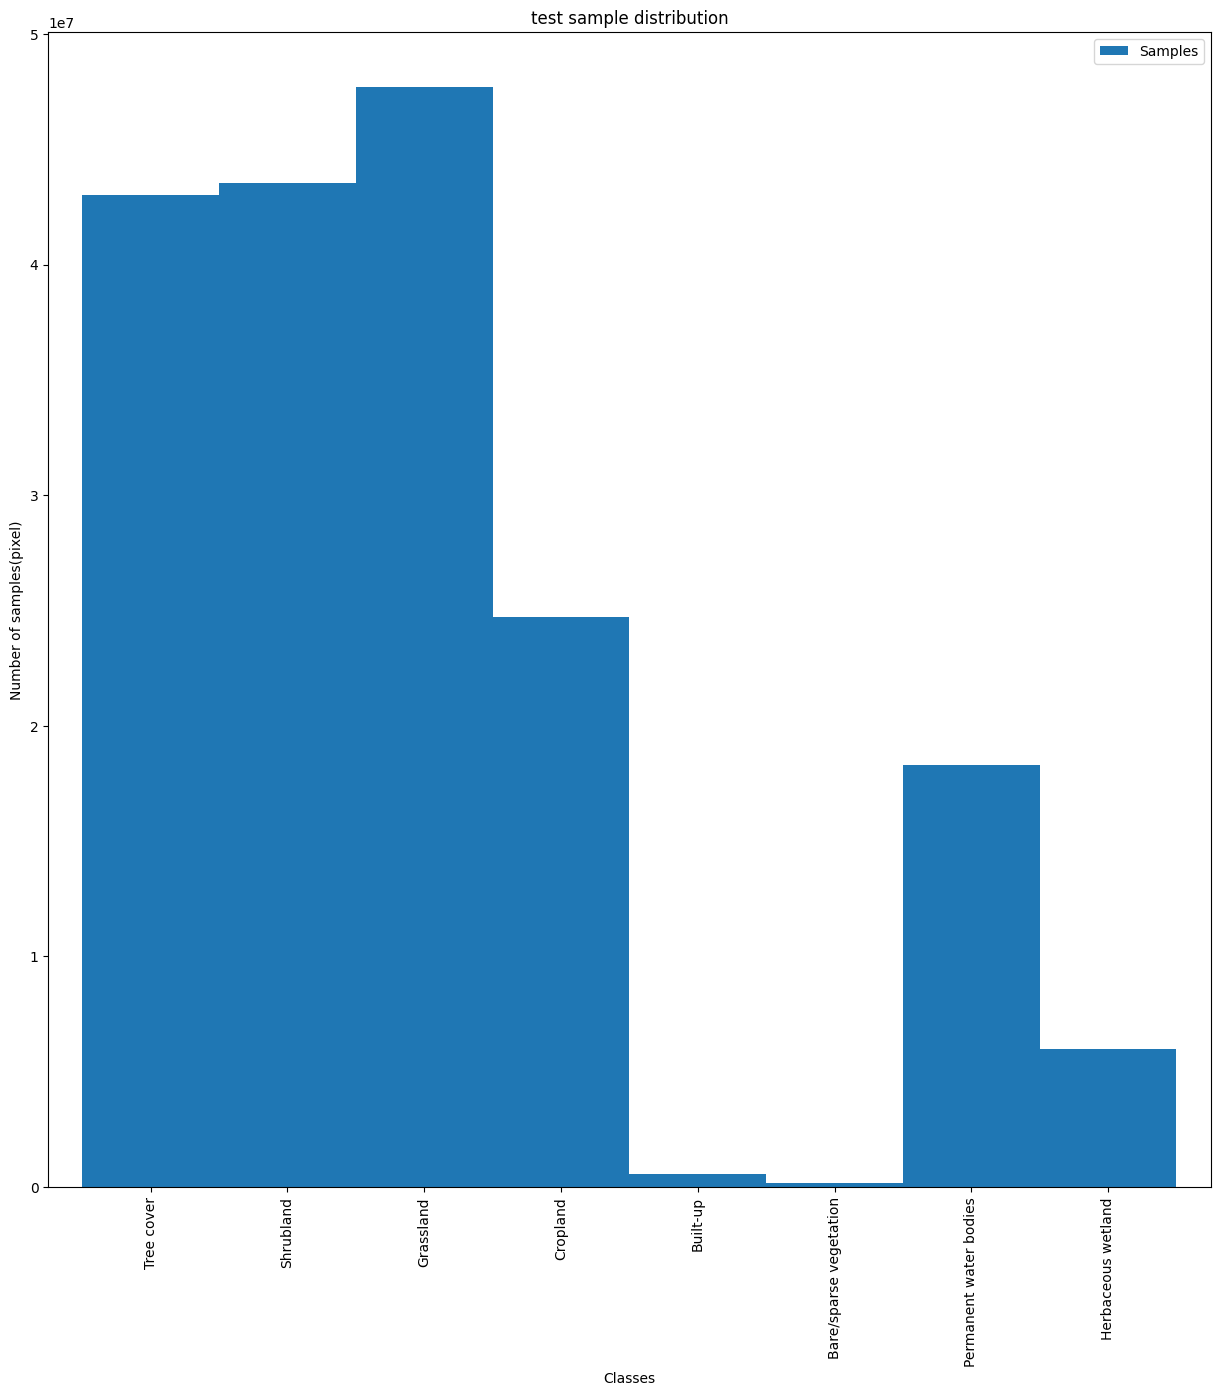

Total valid data:  466


100%|██████████| 466/466 [00:10<00:00, 46.32it/s]


Cover type Tree cover: 21.067
Cover type Shrubland: 19.127
Cover type Grassland: 14.743
Cover type Cropland: 4.755
Cover type Built-up: 1.454
Cover type Bare/sparse vegetation: 0.06
Cover type Permanent water bodies: 34.388
Cover type Herbaceous wetland: 4.407


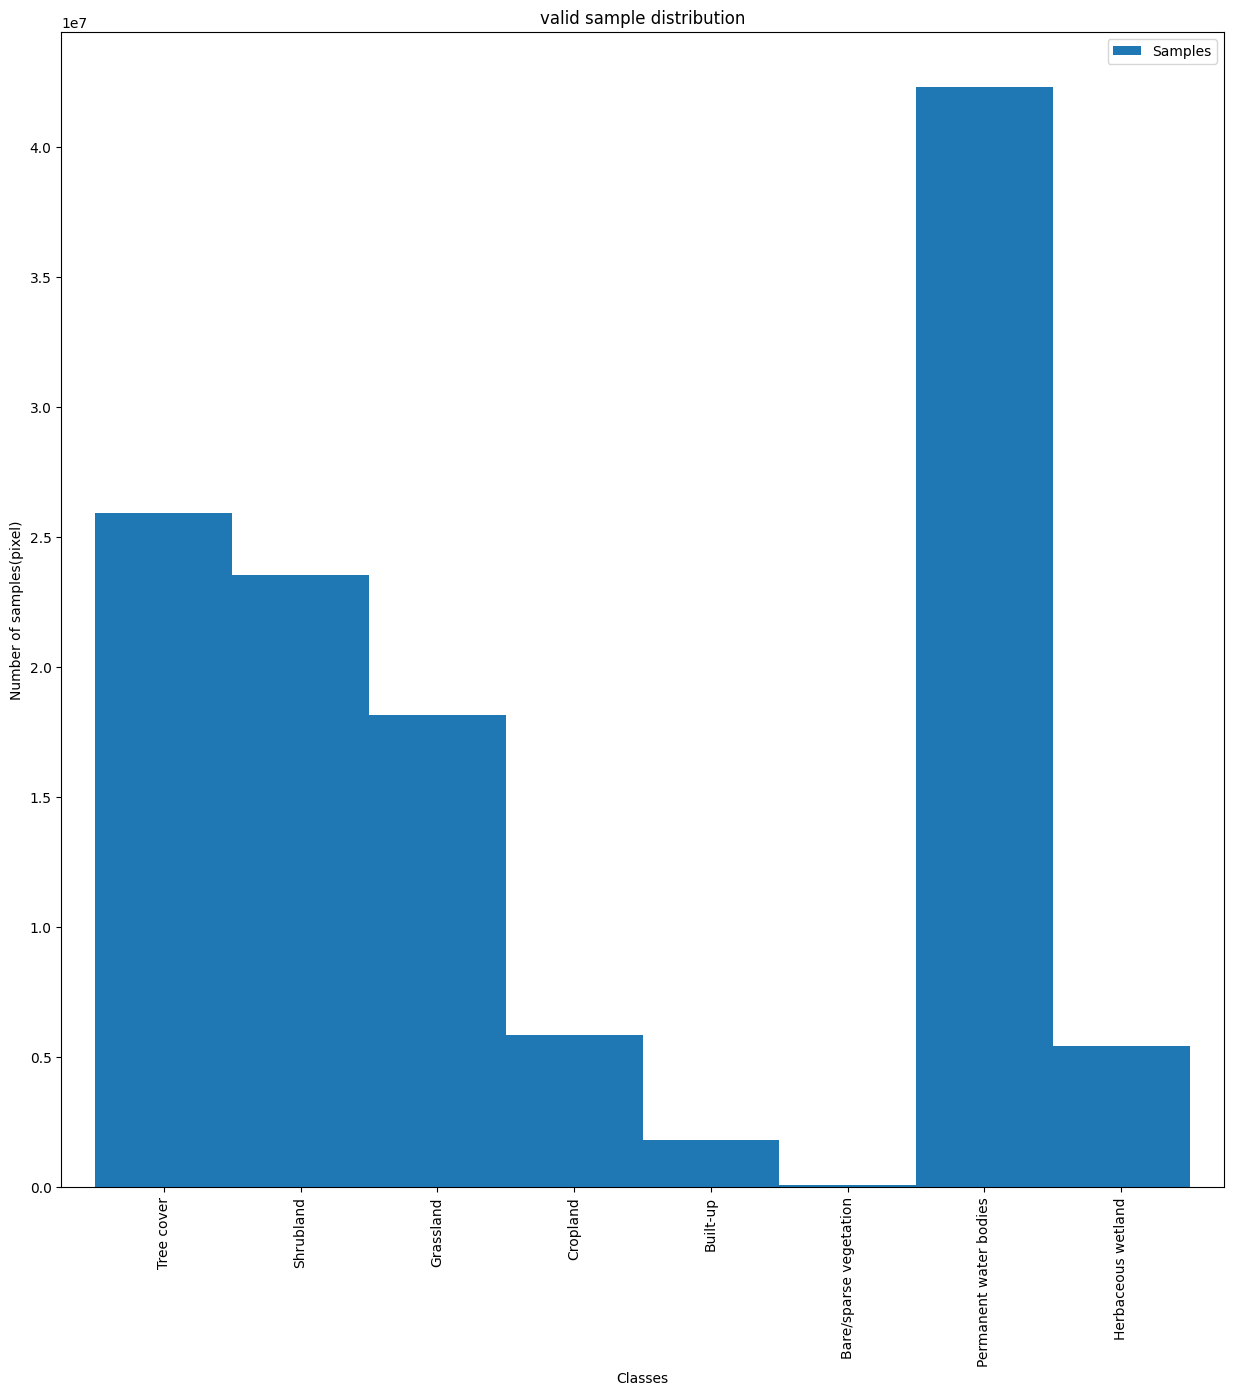

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
%run code/summerise_distribution_filter.py

## Undestanding image statistics for normalization
Bear in mind that for deep learning models data normalization plays a key role in the convergence speed. Therefore, we have planned to perform min-max scaling. 

Min-max scaling could be done as:
$$
image_{scaled} = \frac{(image-image_{min})}{image_{max}-image_{min}}
$$

In [ ]:
def generate_minmax_stat(images, num_channels=4, report=True):
    maxs = np.zeros((len(images), num_channels), dtype=float)
    mins = np.zeros((len(images), num_channels), dtype=float)
    for j, image in tqdm(enumerate(images)):
        array = imread(image)
        assert array.shape[-1] == num_channels, f'specified number of chanels {num_channels} and actual number of channels in the image {array.shape[-1]} are not the same'
        mxs = np.nanmax(array, axis=(0,1))
        mns = np.nanmin(array, axis=(0,1))
        
        for i in range(num_channels):
            maxs[j, i] = mxs[i]
            mins[j, i] = mns[i]
    
    return [np.min(mins, axis=0), np.max(maxs, axis=0)], [mins, maxs]

In [ ]:
files = []
folds = ['test', 'train', 'valid']
for fold in folds:
    files.extend(glob(f'/GORILLA/samples/v2/{fold}/images/*.tif'))
st, rw = generate_stat(files)

### inspect the maximum values per band look the distribution. This is important inspect if there is any extreme outlier values only in few samples which are reprsenting the data distribution.

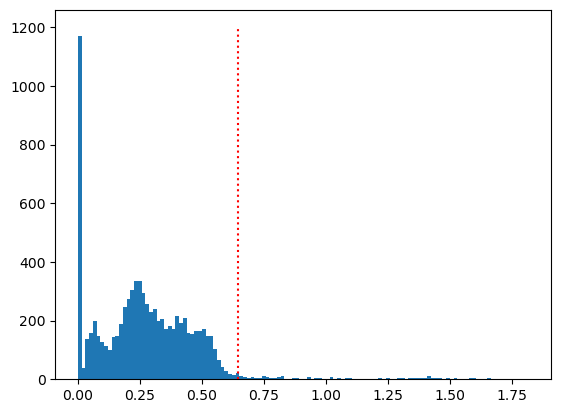

In [ ]:
# generate_stat(files)
xx  = plt.hist(rw[1].ravel(), 120)
plt.vlines(np.percentile(rw[1].ravel(), 97),ymin=0, ymax=1200, colors='r', linestyles='dotted')

## Alternative z-score scaling 
$Z$ score is also called standard scaling. It accounts the mean and standard deviation of the data distribution. Its given as 
$$
image_{scaled} = \frac{image-image_{\mu}}{image_{\delta}}
$$
note that wehn we say image, its mean individual bands

In [ ]:
def generate_mustd_stat(images, height=512, width=512, num_channels=4, report=True):
    all_channels = {}
    keys = ['a', 'b', 'c', 'd']
    for key in keys:
        all_channels[key] = np.zeros((height, width, len(images)), dtype=float)

    for j, image in tqdm(enumerate(images)):
        array = imread(image)
        for vals in list(zip([0, 1, 2, 3], keys)):
            all_channels[vals[1]][:,:, j] = array[:,:,vals[0]]

    vals = [(np.nanmean(all_channels[key]), np.nanstd(all_channels[key])) for key in all_channels.keys()]
    if report:
        for i in range(len(vals)):
            print(f'band {i+1} mean {vals[i][0]} std {vals[i][1]}')
    return vals, all_channels

In [ ]:
root = '/home/getch/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/2/landcover_data_v2'
files = []
folds = ['test', 'train', 'valid']
for fold in folds:
    files.extend(glob(f'{root}/{fold}/images/*.tif'))
print(len(files))
# a, b = generate_mustd_stat(files)
stats, raw = generate_mustd_stat(images=files, height=512, width=512, num_channels=4, report=True)

2095


0it [00:00, ?it/s]

2095it [01:06, 31.37it/s]


band 1 mean 0.040551468815817705 std 0.04558734906216333
band 2 mean 0.05671991797227009 std 0.0473301615731358
band 3 mean 0.05664462136485029 std 0.051660152632441746
band 4 mean 0.1688796614838653 std 0.12516235881460264


### Formating the computed mean and standard deviation values as an areray or tensor for further use
see also how its integrated in the dataset class 

In [ ]:
mus = np.array([0.040551468815817705, 0.05671991797227009, 0.05664462136485029, 0.1688796614838653]).reshape(1,1,4)
stds = np.array([0.04558734906216333, 0.0473301615731358,  0.051660152632441746, 0.12516235881460264]).reshape(1,1,4)

## Other scaling approach based on data type and value ranges
For example if we have an 8bits inter dataset, inprinciple whose range is from 0 to 255, we can simply scale the values as:
$$
image = \frac{image}{255}
$$
which simply could change the data range from 0 to 1

## **Model Training**
The following cell is used to train the model. The model architecture we are using is called the U-net. See the original paper on its implementation provided at [[U-net]](https://arxiv.org/abs/1505.04597) Is one of the most widely used fully convolutional models for semantic segmentation. Its architecture is presented in the figure below.

<p align="center">
<img src="https://i.ibb.co/2WhDbRv/Screenshot-2021-06-12-20-31-16.png" alt="Screenshot-2021-06-12-20-31-16" border="0"></a>
</p>


### The loss function
As we are doing to train a model for muti-class segmentation task, we will use a **Cross entropy loss** as a loss function. The cross entropy loss for multi-class segmentation and or classification tasks could be provided as:
$$
-\sum_{i=0}^n y_{i}log(p_i)
$$

where $n$ is the number of classes and $y_i$ and $p_i$ are reference and predicted probabilities for the $i^{th}$ class respectively. Here we have to note that $p_i$ is the softmax probabilities obtained after enfrcing softmax activation fnction on model outputs(logits). This could be eimplemented either by putting channel wise `nn.SoftMax` as a final layer or `p.softmax()` function on model outpts. To reduce confusion on lituratures on the mathematical representation of cross entropy loss function, the softmax provided as:
$$
\frac{e^{y_i}}{∑_i^n e^{y_i}}
$$

**Note:** while we are feeding the predicted `(p)` and reference `(y)`, we have to take the following cautions.
1. If we use the builtin `torch.nn.CrossEntropyLoss()`, the `p` shod be logits which are not nrmalized. The function runs log and softmax at the backend. The `y` should be either *float onehot encoded tensor* or *class index intiger data type*
2. If we use our custom function, `y` should be *one hot encoded float tensor* and `p` should be *softmax robabilities*. if the otput from the model is logits, enforce the `Softmax` function before computing the loss. For more details, please refer [docmentation of official Pytorch implementation of Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

**Imbalanced class distribution:** In the real world scenarios, the occurunce or class distribution among diference classes is not even. If we simpl enforce the cross entropy loss, the model might be biased towards the most freuent occuring classes. This could be tackeled by introducing the weight factor in the loss. The weights would be the invers of the class freuency where less frequent classes get more weight. Thn the weighted cross entropy coud be given as:

$$-\sum_{i=0}^n w_i y_{i}log(p_i)$$

where the $w_i$ is
$$
w_i = \frac{\sum y_i}{\sum_i^n y_i}
$$
given $i$ is the class index. The cstom implementation of the weight tensor is provided in the following python script.

>> <ins> Python Implementation for weight calculation <ins/>
>>>
```python
def get_class_weight(loader, n_class=8):
    n_train = len(loader)
    class_weight = np.zeros(n_class, dtype=float)
    with tqdm(total=n_train, desc='Class Count Assessment', unit='batch', disable = False, leave=True) as pbar:
        for batch in loader:
            true_masks = batch[1]
            (unique, counts) = np.unique(true_masks, return_counts=True)
            for idx, i in enumerate(unique.tolist()):
                class_weight[i-1] += counts[idx]
            pbar.update()
    class_weight = 1/(class_weight/class_weight.sum())
    return class_weight
```

- ALternative loss functions incase of binary classification

for the binary classification loss, `Bainry cross entropy loss` is the most commnly used term with minor modification of cross entropy loss. Its given as:
$$
-\sum y_i log(p_i) + (1-y_i)log(1-pi)
$$

Here $p_i$ is the proability of being a positive class and $1-p_i$ is the probability of being negative class. Please note that the prediction `p` shoud be a probability obtained from `sigmoid` activation. In addition to binar cross entropy, thogh its mostly used as accuracy metrics, **Dice metrics** could also be used as a loss metrics:
$$
1-\frac{2*\sum (P \cap Y)}{\sum(P \cup Y) + ϵ}
$$

and its also common to combine cross entropy with dice loss functions.

Where:
- p_y_true is the probability of the ith class labels
- p_y_pred is the probability of the ith class prediction
- N_class is the nubmer of classes


>> <ins> Python Implementation <ins/>
>>>
```python
def dice_coef(y_true, y_pred, smooth=1e-7):
    assert y_true.shape == y_pred.shape, f'Reference and predicted label shapes {y_true.shape} and {y_pred.shape} are not the same!'
    y_pred = torch.softmax(y_pred, dim=1) # expecting the last layer is a logit
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersect = torch.sum(y_true_f * y_pred_f, axis=-1)
    denom = torch.sum(y_true_f + y_pred_f, axis=-1)
    return torch.mean((2. * intersect / (denom + smooth)))
def dice_coef_9cat_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
```
    
    
### Command line guidelines for training

Use the following commandline parameters and respective values to run the traing script provided in  /content/drive/MyDrive/code/train.py

`-f` : Used to load a model already stored in memory.\
`-e` : Used to specify the Number of training epochs.\
`-l` : Used to specify the learning rate to be used for training.\
`-b` : Used to specify the batch size \
`-n` : indicate the number of classes in the mask/label and or model\
`-z` : wther to perform onehot encoding of the masks for cross entropy loss\
`-q` : to indicate wether to resise the image to intended spatial sise or not
`-c` : specify the Number of channels in the input image\
`-t` : to indicate training data folder \
`-v` : to indicate validation data folder \
`-x` : to specify image and labnel file extension \
`-s` : to indicate the shape or spatial dimension of the input image \
`-d` : to indicate the directory to save the checkpoint and results\
`-w` : to specify whether the digitalglob or esa landcover dataset to use\ 

In [16]:
# !python3 /home/getch/meta/code/train.py -e 250 -l 20e-6 -b 32 -n 7 -c 3 -t /home/getch/ssl/GORILLA/DIGITAL_glob_datasetb -x .tif -s 256 -d /home/getch/ssl/GORILLA/results -v /home/getch/ssl/GORILLA/DIGITAL_glob_dataset -w digitalglobe 

In [1]:
!python3 /home/getch/meta/code/train.py -e 250 -l 20e-6 -b 32 -n 8 -c 4 -t /home/getch/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/2/landcover_data_v2 -x .tif -s 256 -d /home/getch/ssl/GORILLA/results -v /home/getch/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/2/landcover_data_v2 -w esalandcover 

# Visualize training logs

In [6]:
# read the loss files saved as csv inside the results folder and plots
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

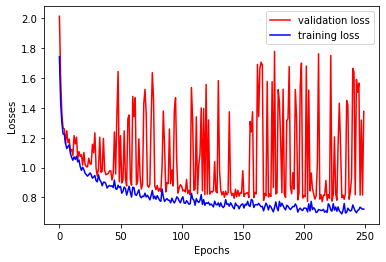

In [25]:
df = pd.read_csv('/home/getch/ssl/GORILLA/results/esalandcover/checkpoints/tt_ff_train_val_loss.csv')
plt.plot(df['valid_loss'], label='validation loss', c='red')
plt.plot(df['train_loss'], label='training loss', c='blue')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

## **Model Evaluation**
The following cell is used to evaluate the trained model on the test set. Please bear in mind that the data provided in the validation set is systematically partitioned to validation and test sets which are mutually exclusive sample sets. This can be easily noted in the file /content/drive/MyDrive/code/train.py **lines 49 and 51**

```python
valid_impages = sorted(glob(f'{val_data_dir}/images/*{ext}'))
valid_impages = [valid_impages[i] for i in list(range(0, len(valid_impages),2))]
valid_labels = sorted(glob(f'{val_data_dir}/labels/*{ext}'))
valid_labels = [valid_labels[i] for i in list(range(0, len(valid_labels),2))]
valid_dataset = LandDataset(imgs=valid_impages, lbls=valid_labels, n_classes=n_class, shape=shape)
    
```


The metric of evaluation is the Mean Intersection over Union(MIoU) score. Its computes the areaal overlap of the computed and reference labels. It could be asily understood from the following graphics for semantic segmentation obect detection. See the following demo on toy data created using the code in the following cell.

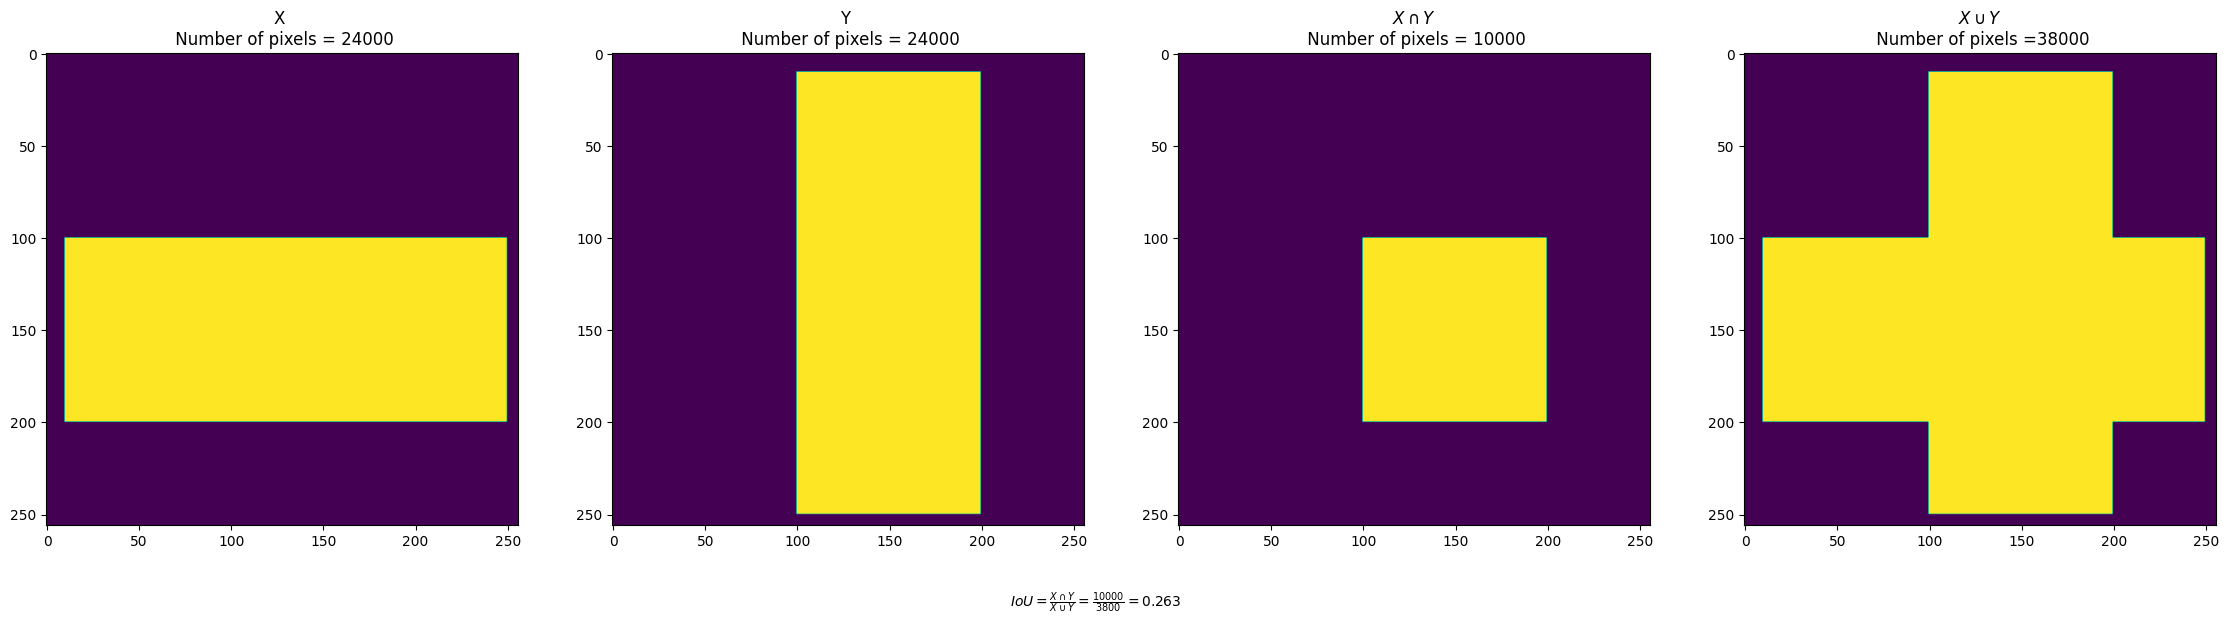

In [ ]:
from glob import glob
from skimage.io import imread
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False


x = np.zeros((256, 256), dtype=int)
x[100:200,10:250] = 1

y = np.zeros((256, 256), dtype=int)
y[10:250,100:200] = 1

inter = x*y
union = (x+y) > 0

stat = [x.sum(), y.sum(), inter.sum(), union.astype(int).sum()]

titles = ['X \n {} = {}', 'Y \n {} = {}', '$X \cap Y$ \n {} = {}', '$X \cup Y$ \n {} ={}']
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
ax[0].imshow(x)
ax[1].imshow(y)
ax[2].imshow(inter)
ax[3].imshow(union.astype(int))
for i, title in enumerate(titles):
  ax[i].set_title(title.format('Number of pixels', stat[i]))
fig.text(0.5, 0.04, r'$IoU = \frac{X \cap Y}{X \cup Y} = \frac{10000}{3800} = 0.263$', ha='center')
plt.show()

<p align="center">
<img src="https://learnopencv.com/wp-content/uploads/2022/12/intersection-over-union-iou.jpg" alt="intersection-over-union-iou" border="0"></a>
</p>

<ins>_Guidelines_<ins>

`-m` : Used to specify the directory to the model.\
`-i` : Used to specify the directory of the images to test the model on.\
`-o` : Used to specify the directory in which the predictions will be outputed.\
`-t` : Minimum probability value to consider a mask pixel white. \
`-n` : number of classes in mask or model definition.\
`-c` : Number of input chnannels in the model definition. \
`-s` : spatial dimension of the input images. \
`-b` : Batch size use for test data loader. \
(For best results used the same scale you used for training the model)

_Note:_ Bear in mind that the test dataset should undergo the same preprocessing nd scaing or normalization. Unless the model might perform poorl on the test dataset.


In [2]:
%%time
!python /home/getch/meta/code/predict.py -p -w esalandcover # -m /home/getch/ssl/GORILLA/results/esalandcover/checkpoints/ff_best_weight.pth -i /home/getch/.cache/kagglehub/datasets/getachewworkineh/uganda-landcover/versions/1/samples/test # -o -k -n -c -s -b

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.4 µs
